<a href="https://colab.research.google.com/github/mebalint/hgt_m_csapat/blob/main/hgt_m_csapat_adat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import json
from collections import defaultdict
import pandas as pd
import requests, zipfile, json, io
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
def data_download():
    """
    Downloading script for soccer logs public open dataset:
    https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
    Data description available here:
    Please cite the source as:
    Pappalardo, L., Cintia, P., Rossi, A. et al. A public data set of spatio-temporal match events in soccer competitions. 
    Scientific Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7
    """

    dataset_links = {

    'matches' : 'https://ndownloader.figshare.com/files/14464622',
    'events' : 'https://ndownloader.figshare.com/files/14464685',
    'players' : 'https://ndownloader.figshare.com/files/15073721',
    'teams': 'https://ndownloader.figshare.com/files/15073697',
    'competitions': 'https://ndownloader.figshare.com/files/15073685'
    }

    print ("Downloading matches data")
    r = requests.get(dataset_links['matches'], stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("data/matches")

    
    print ("Downloading teams data")
    r = requests.get(dataset_links['teams'], stream=False)
    print (r.text, file=open('data/teams.json','w'))


    print ("Downloading players data")
    r = requests.get(dataset_links['players'], stream=False)
    print (r.text, file=open('data/players.json','w'))
    
    print ("Downloading competitions data")
    r = requests.get(dataset_links['competitions'], stream=False)
    print (r.text, file=open('data/competitions.json','w'))
    
    print ("Downloading events data")
    r = requests.get(dataset_links['events'], stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("data/events")
    
    print ("Download completed")

In [ ]:
data_download()

Download completed


In [ ]:
data_folder='data/'

In [ ]:
def load_public_dataset(data_folder=data_folder, tournaments=['Italy','England','Germany', 'France', 
             'Spain']):
    """
    Load the json files with the matches, events, players and competitions
    
    Parameters
    ----------
    data_folder : str, optional
        the path to the folder where json files are stored. Default: 'data/'
        
    tournaments : list, optional
        the list of tournaments to load. 
        
    Returns
    -------
    tuple
        a tuple of four dictionaries, containing matches, events, players and competitions
        
    """
    # loading the matches and events data

    match_id2events = defaultdict(list)
    match_id2match = defaultdict(dict)

    for tournament in tournaments:
        matches, events = {}, {}
        with open('./data/events/events_%s.json' %tournament) as json_data:
            events = json.load(json_data)
        with open('./data/matches/matches_%s.json' %tournament) as json_data:
            matches = json.load(json_data)
        
        
        for event in events:
            match_id = event['matchId']
            match_id2events[match_id].append(event)
                                            
        for match in matches:
            match_id = match['wyId']
            match_id2match[match_id] = match
                                   
    # loading the players data
    with open('./data/players.json') as json_data:
        players = json.load(json_data)
    
    player_id2player = defaultdict(dict)
    for player in players:
        player_id = player['wyId']
        player_id2player[player_id] = player
    
    # loading the competitions data
    competitions={}
    with open('./data/competitions.json') as json_data:
        competitions = json.load(json_data)
    competition_id2competition = defaultdict(dict)
    for competition in competitions:
        competition_id = competition['wyId']
        competition_id2competition[competition_id] = competition
    
    # loading the competitions data
    teams={}
    with open('./data/teams.json') as json_data:
        teams = json.load(json_data)
    team_id2team = defaultdict(dict)
    for team in teams:
        team_id = team['wyId']
        team_id2team[team_id] = team
    
    return match_id2match, match_id2events, player_id2player, competition_id2competition, team_id2team

In [ ]:
match_id2match, match_id2events, player_id2player, competition_id2competition, team_id2team = load_public_dataset()

### Rest

In [ ]:
# to get team_id from team name
team2team_id={}
for i in range(len(list(team_id2team.keys()))):
  team2team_id[list(team_id2team.values())[i]['name']]=list(team_id2team.keys())[i]
team2team_id['Angers']
team2team_id['Angers SCO']=3799

In [ ]:
# to get a result
list(match_id2match.values())[380]['label']


'Burnley - AFC Bournemouth, 1 - 2'

In [ ]:
# dataframe from data
matches=pd.DataFrame.from_dict(match_id2match, orient='index', columns=['label', 'roundId', 'gameweek', 'competitionId'])
matches['home']=matches['label'].str.split(', ', expand=True)[0].str.split(' - ', expand=True)[0]
matches['away']=matches['label'].str.split(', ', expand=True)[0].str.split(' - ', expand=True)[1]
matches['home_goal']=matches['label'].str.split(', ', expand=True)[1].str.split(' - ', expand=True)[0]
matches['away_goal']=matches['label'].str.split(', ', expand=True)[1].str.split(' - ', expand=True)[1]
matches=matches[['home', 'away', 'home_goal', 'away_goal', 'roundId', 'gameweek', 'competitionId']]
matches

,home,away,home_goal,away_goal,roundId,gameweek,competitionId
2576335,Lazio,Internazionale,2,3,4406278,38,524
2576336,Sassuolo,Roma,0,1,4406278,38,524
2576329,Cagliari,Atalanta,1,0,4406278,38,524
2576330,Chievo,Benevento,1,0,4406278,38,524
2576331,Udinese,Bologna,1,0,4406278,38,524
...,...,...,...,...,...,...,...
2565552,Sevilla,Espanyol,1,1,4406122,1,795
2565551,Girona,Atl\u00e9tico Madrid,2,2,4406122,1,795
2565549,Celta de Vigo,Real Sociedad,2,3,4406122,1,795
2565556,Valencia,Las Palmas,1,0,4406122,1,795


In [ ]:
# corner stat
home_corner={}
away_corner={}
for index in matches.index:
    match_df = pd.DataFrame(match_id2events[index])
    teams_df=match_df[match_df['subEventName']=='Corner']['teamId'].value_counts()
    corner_dict={}
    for ind in teams_df.index:
        corner_dict[ind]=teams_df[ind]
    if team2team_id[matches['home'][index]] in corner_dict:
        home_corner[index]=corner_dict[team2team_id[matches['home'][index]]]
    else:
        home_corner[index]=0
    if team2team_id[matches['away'][index]] in corner_dict:
        away_corner[index]=corner_dict[team2team_id[matches['away'][index]]]
    else:
        away_corner[index]=0

In [ ]:
matches['home_corner']=matches.index.map(home_corner)
matches['away_corner']=matches.index.map(away_corner)

In [ ]:
# stats for the dataframe
for stat_type in ['Pass','Duel', 'Foul', 'Save attempt', 'Shot']:
    home_stat={}
    away_stat={}
    for index in matches.index:
        match_df = pd.DataFrame(match_id2events[index])
        teams_df=match_df[match_df['eventName']==stat_type]['teamId'].value_counts()
        stat_dict={}
        for ind in teams_df.index:
            stat_dict[ind]=teams_df[ind]
        if team2team_id[matches['home'][index]] in stat_dict:
            home_stat[index]=stat_dict[team2team_id[matches['home'][index]]]
        else:
            home_stat[index]=0
        if team2team_id[matches['away'][index]] in stat_dict:
            away_stat[index]=stat_dict[team2team_id[matches['away'][index]]]
        else:
            away_stat[index]=0
    matches['home_'+stat_type.lower()]=matches.index.map(home_stat)
    matches['away_'+stat_type.lower()]=matches.index.map(away_stat)

In [ ]:
# shot on target stat
home_stat={}
away_stat={}
for index in matches.index:
    match_df = pd.DataFrame(match_id2events[index])
    teams_df=match_df[(match_df['eventName']=='Shot')][['{\'id\': 1801}' in str(match_df[(match_df['eventName']=='Shot')]['tags'][index]) for index in match_df[(match_df['eventName']=='Shot')].index]]['teamId'].value_counts()
    stat_dict={}
    for ind in teams_df.index:
        stat_dict[ind]=teams_df[ind]
    if team2team_id[matches['home'][index]] in stat_dict:
        home_stat[index]=stat_dict[team2team_id[matches['home'][index]]]
    else:
        home_stat[index]=0
    if team2team_id[matches['away'][index]] in stat_dict:
        away_stat[index]=stat_dict[team2team_id[matches['away'][index]]]
    else:
        away_stat[index]=0
matches['home_shot_on_target']=matches.index.map(home_stat)
matches['away_shot_on_target']=matches.index.map(away_stat)

In [ ]:
# free kick stat
stat_type=['Free Kick','Free kick shot', 'Free kick cross']
home_stat={}
away_stat={}
for index in matches.index:
    match_df = pd.DataFrame(match_id2events[index])
    teams_df=match_df[(match_df['subEventName']==stat_type[0]) | (match_df['subEventName']==stat_type[1]) | (match_df['subEventName']==stat_type[2])]['teamId'].value_counts()
    stat_dict={}
    for ind in teams_df.index:
        stat_dict[ind]=teams_df[ind]
    if team2team_id[matches['home'][index]] in stat_dict:
        home_stat[index]=stat_dict[team2team_id[matches['home'][index]]]
    else:
        home_stat[index]=0
    if team2team_id[matches['away'][index]] in stat_dict:
        away_stat[index]=stat_dict[team2team_id[matches['away'][index]]]
    else:
        away_stat[index]=0
matches['home_free_kick']=matches.index.map(home_stat)
matches['away_free_kick']=matches.index.map(away_stat)

In [ ]:
matches

,home,away,home_goal,away_goal,roundId,gameweek,competitionId,home_corner,away_corner,home_pass,...,home_foul,away_foul,home_save attempt,away_save attempt,home_shot,away_shot,home_shot_on_target,away_shot_on_target,home_free_kick,away_free_kick
2576335,Lazio,Internazionale,2,3,4406278,38,524,10,3,302,...,14,14,7,5,14,14,4,6,14,13
2576336,Sassuolo,Roma,0,1,4406278,38,524,5,9,337,...,14,10,7,3,14,15,3,6,12,16
2576329,Cagliari,Atalanta,1,0,4406278,38,524,5,11,232,...,18,14,4,4,6,11,4,4,16,15
2576330,Chievo,Benevento,1,0,4406278,38,524,2,4,198,...,13,11,3,4,6,10,4,2,12,15
2576331,Udinese,Bologna,1,0,4406278,38,524,10,2,327,...,9,10,4,5,17,8,5,4,13,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565552,Sevilla,Espanyol,1,1,4406122,1,795,7,3,586,...,18,12,6,6,10,9,5,6,12,20
2565551,Girona,Atl\u00e9tico Madrid,2,2,4406122,1,795,6,0,433,...,15,17,3,6,11,8,5,3,18,15
2565549,Celta de Vigo,Real Sociedad,2,3,4406122,1,795,5,4,432,...,13,11,6,6,15,10,5,5,11,14
2565556,Valencia,Las Palmas,1,0,4406122,1,795,5,2,433,...,23,13,3,6,19,3,6,3,14,25


In [ ]:
matches.columns

Index(['home', 'away', 'home_goal', 'away_goal', 'roundId', 'gameweek',
       'competitionId', 'home_corner', 'away_corner', 'home_pass', 'away_pass',
       'home_duel', 'away_duel', 'home_foul', 'away_foul', 'home_save attempt',
       'away_save attempt', 'home_shot', 'away_shot', 'home_shot_on_target',
       'away_shot_on_target', 'home_free_kick', 'away_free_kick'],
      dtype='object')

In [ ]:
odds_df=pd.read_csv('https://raw.githubusercontent.com/mebalint/hgt/main/bundesliga.csv', sep='\t', index_col=0)
odds_df=pd.concat([odds_df, pd.read_csv('https://raw.githubusercontent.com/mebalint/hgt/main/laliga.csv', sep='\t', index_col=0)])
odds_df=pd.concat([odds_df, pd.read_csv('https://raw.githubusercontent.com/mebalint/hgt/main/ligue1.csv', sep='\t', index_col=0)])
odds_df=pd.concat([odds_df,pd.read_csv('https://raw.githubusercontent.com/mebalint/hgt/main/premierleague.csv', sep='\t', index_col=0)])
odds_df=pd.concat([odds_df,pd.read_csv('https://raw.githubusercontent.com/mebalint/hgt/main/seriea.csv', sep='\t', index_col=0)])
odds_df.columns=['label', 'home_odds', 'draw_odds', 'away_odds']
odds_df['home']=odds_df['label'].str.split(' - ', expand=True)[0]
odds_df['away']=odds_df['label'].str.split(' - ', expand=True)[1].str.split(':', expand=True)[0].str.rsplit(' ', 1, expand=True)[0]
odds_df['home_goal']=odds_df['label'].str.split(' - ', expand=True)[1].str.split(':', expand=True)[0].str.rsplit(' ', 1, expand=True)[1]
odds_df['away_goal']=odds_df['label'].str.split(' - ', expand=True)[1].str.split(':', expand=True)[1]
odds_df=odds_df.drop(columns='label')
odds_df


,home_odds,draw_odds,away_odds,home,away,home_goal,away_goal
0,2.33,3.71,2.90,Holstein Kiel,Wolfsburg,0,1
1,2.00,3.39,4.09,Wolfsburg,Holstein Kiel,3,1
2,1.21,7.31,12.34,Bayer Leverkusen,Hannover,3,2
3,2.07,3.17,4.07,Freiburg,Augsburg,2,0
4,4.28,3.98,1.80,Hertha Berlin,RB Leipzig,2,6
...,...,...,...,...,...,...,...
375,7.07,4.24,1.50,Crotone,AC Milan,0,3
376,1.28,5.82,11.13,Lazio,Spal,0,0
377,1.93,3.54,4.16,Sassuolo,Genoa,0,0
378,2.90,3.42,2.46,Atalanta,AS Roma,0,1


In [ ]:
club_names_odds=set(list(odds_df['home']))

In [ ]:
club_names_df=set(list(matches['home']))

In [ ]:
club_names_df.difference(club_names_odds)

{'AFC Bournemouth',
 'Amiens SC',
 'Angers SCO',
 'Athletic Club',
 'Atl\\u00e9tico Madrid',
 'Bayern M\\u00fcnchen',
 'Borussia Dortmund',
 "Borussia M'gladbach",
 'Brighton & Hove Albion',
 'Celta de Vigo',
 'Deportivo Alav\\u00e9s',
 'Deportivo La Coru\\u00f1a',
 'Hannover 96',
 'Hellas Verona',
 'Hertha BSC',
 'Huddersfield Town',
 'Internazionale',
 'K\\u00f6ln',
 'Legan\\u00e9s',
 'Leicester City',
 'M\\u00e1laga',
 'Mainz 05',
 'Manchester United',
 'Milan',
 'Newcastle United',
 'Olympique Lyonnais',
 'Olympique Marseille',
 'PSG',
 'Real Betis',
 'Roma',
 'SPAL',
 'Saint-\\u00c9tienne',
 'Schalke 04',
 'Stoke City',
 'Swansea City',
 'Tottenham Hotspur',
 'West Bromwich Albion',
 'West Ham United'}

In [ ]:
club_names_odds.difference(club_names_df)

{'AC Ajaccio',
 'AC Milan',
 'AS Roma',
 'Alaves',
 'Amiens',
 'Ath Bilbao',
 'Atl. Madrid',
 'B. Monchengladbach',
 'Bayern Munich',
 'Betis',
 'Bournemouth',
 'Brighton',
 'Celta Vigo',
 'Dep. La Coruna',
 'Dortmund',
 'FC Koln',
 'Hannover',
 'Hertha Berlin',
 'Holstein Kiel',
 'Huddersfield',
 'Inter',
 'Le Havre',
 'Leganes',
 'Leicester',
 'Lyon',
 'Mainz',
 'Malaga',
 'Manchester Utd',
 'Marseille',
 'Newcastle',
 'Paris SG',
 'Schalke',
 'Spal',
 'St Etienne',
 'Stoke',
 'Swansea',
 'Tottenham',
 'Verona',
 'West Brom',
 'West Ham'}

In [ ]:
odds_df_dict={'Angers SCO': 'Angers','Huddersfield Town': 'Huddersfield',
 'West Ham United': 'West Ham',
 'Athletic Club': 'Ath Bilbao',
 'Tottenham Hotspur': 'Tottenham',
 'AFC Bournemouth':'Bournemouth',
 'Borussia Dortmund': 'Dortmund',
 'Hellas Verona': 'Verona',
 'SPAL': 'Spal',
 'Schalke 04': 'Schalke',
 'PSG': 'Paris SG',
 'Olympique Marseille': 'Marseille',
 'Leicester City': 'Leicester',
 'K\\u00f6ln': 'FC Koln',
 'Stoke City': 'Stoke',
 'Milan': 'AC Milan',
 'Deportivo Alav\\u00e9s': 'Alaves',
 'West Bromwich Albion': 'West Brom',
 'Newcastle United': 'Newcastle',
 'Manchester United': 'Manchester Utd',
 'Real Betis': 'Betis',
 'Bayern M\\u00fcnchen': 'Bayern Munich',
 'Roma': 'AS Roma',
 'Hertha BSC': 'Hertha Berlin',
 "Borussia M'gladbach": 'B. Monchengladbach',
 'Atl\\u00e9tico Madrid': 'Atl. Madrid',
 'Olympique Lyonnais': 'Lyon',
 'Brighton & Hove Albion': 'Brighton',
 'Mainz 05': 'Mainz',
 'M\\u00e1laga': 'Malaga',
 'Internazionale': 'Inter',
 'Celta de Vigo': 'Celta Vigo',
 'Legan\\u00e9s': 'Leganes',
 'Swansea City': 'Swansea',
 'Amiens SC': 'Amiens',
 'Saint-\\u00c9tienne': 'St Etienne',
 'Hannover 96': 'Hannover',
 'Deportivo La Coru\\u00f1a': 'Dep. La Coruna'}

In [ ]:
matches['home']=[odds_df_dict[team] if team in odds_df_dict else team for team in list(matches['home'])]
matches['away']=[odds_df_dict[team] if team in odds_df_dict else team for team in list(matches['away'])]

In [ ]:
matches

,home,away,home_goal,away_goal,roundId,gameweek,competitionId,home_corner,away_corner,home_pass,...,home_foul,away_foul,home_save attempt,away_save attempt,home_shot,away_shot,home_shot_on_target,away_shot_on_target,home_free_kick,away_free_kick
2576335,Lazio,Inter,2,3,4406278,38,524,10,3,302,...,14,14,7,5,14,14,4,6,14,13
2576336,Sassuolo,AS Roma,0,1,4406278,38,524,5,9,337,...,14,10,7,3,14,15,3,6,12,16
2576329,Cagliari,Atalanta,1,0,4406278,38,524,5,11,232,...,18,14,4,4,6,11,4,4,16,15
2576330,Chievo,Benevento,1,0,4406278,38,524,2,4,198,...,13,11,3,4,6,10,4,2,12,15
2576331,Udinese,Bologna,1,0,4406278,38,524,10,2,327,...,9,10,4,5,17,8,5,4,13,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565552,Sevilla,Espanyol,1,1,4406122,1,795,7,3,586,...,18,12,6,6,10,9,5,6,12,20
2565551,Girona,Atl. Madrid,2,2,4406122,1,795,6,0,433,...,15,17,3,6,11,8,5,3,18,15
2565549,Celta Vigo,Real Sociedad,2,3,4406122,1,795,5,4,432,...,13,11,6,6,15,10,5,5,11,14
2565556,Valencia,Las Palmas,1,0,4406122,1,795,5,2,433,...,23,13,3,6,19,3,6,3,14,25


In [ ]:
matches['match_id']=matches.index
matches

,home,away,home_goal,away_goal,roundId,gameweek,competitionId,home_corner,away_corner,home_pass,...,away_foul,home_save attempt,away_save attempt,home_shot,away_shot,home_shot_on_target,away_shot_on_target,home_free_kick,away_free_kick,match_id
2576335,Lazio,Inter,2,3,4406278,38,524,10,3,302,...,14,7,5,14,14,4,6,14,13,2576335
2576336,Sassuolo,AS Roma,0,1,4406278,38,524,5,9,337,...,10,7,3,14,15,3,6,12,16,2576336
2576329,Cagliari,Atalanta,1,0,4406278,38,524,5,11,232,...,14,4,4,6,11,4,4,16,15,2576329
2576330,Chievo,Benevento,1,0,4406278,38,524,2,4,198,...,11,3,4,6,10,4,2,12,15,2576330
2576331,Udinese,Bologna,1,0,4406278,38,524,10,2,327,...,10,4,5,17,8,5,4,13,11,2576331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565552,Sevilla,Espanyol,1,1,4406122,1,795,7,3,586,...,12,6,6,10,9,5,6,12,20,2565552
2565551,Girona,Atl. Madrid,2,2,4406122,1,795,6,0,433,...,17,3,6,11,8,5,3,18,15,2565551
2565549,Celta Vigo,Real Sociedad,2,3,4406122,1,795,5,4,432,...,11,6,6,15,10,5,5,11,14,2565549
2565556,Valencia,Las Palmas,1,0,4406122,1,795,5,2,433,...,13,3,6,19,3,6,3,14,25,2565556


In [ ]:
match_df=matches.merge(odds_df, how='inner', on=['home', 'away', 'home_goal', 'away_goal'])
match_df2=matches.merge(odds_df, how='left', on=['home', 'away', 'home_goal', 'away_goal'])

In [ ]:
match_df

,home,away,home_goal,away_goal,roundId,gameweek,competitionId,home_corner,away_corner,home_pass,...,home_shot,away_shot,home_shot_on_target,away_shot_on_target,home_free_kick,away_free_kick,match_id,home_odds,draw_odds,away_odds
0,Lazio,Inter,2,3,4406278,38,524,10,3,302,...,14,14,4,6,14,13,2576335,2.58,3.61,2.68
1,Sassuolo,AS Roma,0,1,4406278,38,524,5,9,337,...,14,15,3,6,12,16,2576336,4.53,3.77,1.78
2,Cagliari,Atalanta,1,0,4406278,38,524,5,11,232,...,6,11,4,4,16,15,2576329,3.18,3.57,2.21
3,Chievo,Benevento,1,0,4406278,38,524,2,4,198,...,6,10,4,2,12,15,2576330,1.69,3.99,4.90
4,Udinese,Bologna,1,0,4406278,38,524,10,2,327,...,17,8,5,4,13,11,2576331,1.51,4.25,6.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799,Sevilla,Espanyol,1,1,4406122,1,795,7,3,586,...,10,9,5,6,12,20,2565552,1.61,4.06,5.84
1800,Girona,Atl. Madrid,2,2,4406122,1,795,6,0,433,...,11,8,5,3,18,15,2565551,6.63,3.90,1.58
1801,Celta Vigo,Real Sociedad,2,3,4406122,1,795,5,4,432,...,15,10,5,5,11,14,2565549,2.08,3.46,3.70
1802,Valencia,Las Palmas,1,0,4406122,1,795,5,2,433,...,19,3,6,3,14,25,2565556,1.76,3.97,4.58


In [ ]:
match_df2

,home,away,home_goal,away_goal,roundId,gameweek,competitionId,home_corner,away_corner,home_pass,...,home_shot,away_shot,home_shot_on_target,away_shot_on_target,home_free_kick,away_free_kick,match_id,home_odds,draw_odds,away_odds
0,Lazio,Inter,2,3,4406278,38,524,10,3,302,...,14,14,4,6,14,13,2576335,2.58,3.61,2.68
1,Sassuolo,AS Roma,0,1,4406278,38,524,5,9,337,...,14,15,3,6,12,16,2576336,4.53,3.77,1.78
2,Cagliari,Atalanta,1,0,4406278,38,524,5,11,232,...,6,11,4,4,16,15,2576329,3.18,3.57,2.21
3,Chievo,Benevento,1,0,4406278,38,524,2,4,198,...,6,10,4,2,12,15,2576330,1.69,3.99,4.90
4,Udinese,Bologna,1,0,4406278,38,524,10,2,327,...,17,8,5,4,13,11,2576331,1.51,4.25,6.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,Sevilla,Espanyol,1,1,4406122,1,795,7,3,586,...,10,9,5,6,12,20,2565552,1.61,4.06,5.84
1822,Girona,Atl. Madrid,2,2,4406122,1,795,6,0,433,...,11,8,5,3,18,15,2565551,6.63,3.90,1.58
1823,Celta Vigo,Real Sociedad,2,3,4406122,1,795,5,4,432,...,15,10,5,5,11,14,2565549,2.08,3.46,3.70
1824,Valencia,Las Palmas,1,0,4406122,1,795,5,2,433,...,19,3,6,3,14,25,2565556,1.76,3.97,4.58


In [ ]:
diff_df=pd.concat([match_df,match_df2]).drop_duplicates(keep=False).drop(columns=['home_odds',	'draw_odds',	'away_odds'])
#diff_df['away']=diff_df['away'].str.rstrip()
diff_df

,home,away,home_goal,away_goal,roundId,gameweek,competitionId,home_corner,away_corner,home_pass,...,away_foul,home_save attempt,away_save attempt,home_shot,away_shot,home_shot_on_target,away_shot_on_target,home_free_kick,away_free_kick,match_id
388,Tottenham,Leicester,5,4,4405654,38,364,4,4,441,...,14,9,9,13,17,6,9,16,11,2500097
392,Tottenham,Newcastle,1,0,4405654,31,364,6,4,549,...,8,3,6,10,13,4,3,9,14,2500027
406,Tottenham,Watford,2,0,4405654,36,364,4,0,548,...,10,5,3,12,11,3,5,13,14,2500077
429,Tottenham,Manchester City,1,3,4405654,34,364,5,7,443,...,14,7,3,8,14,3,6,13,15,2500057
477,Tottenham,Huddersfield,2,0,4405654,29,364,8,1,785,...,8,3,7,14,3,7,3,10,10,2500007
499,Tottenham,Arsenal,1,0,4405654,27,364,10,2,488,...,10,1,8,15,6,5,1,15,14,2499987
512,Tottenham,Manchester Utd,2,0,4405654,25,364,6,3,501,...,13,3,7,22,6,6,3,21,11,2499968
533,Tottenham,Everton,4,0,4405654,23,364,3,3,549,...,15,0,10,20,5,10,0,22,13,2499946
540,Tottenham,West Ham,1,1,4405654,21,364,7,1,666,...,8,2,8,28,3,6,2,10,12,2499926
569,Tottenham,Southampton,5,2,4405654,20,364,3,8,469,...,15,8,6,15,16,6,7,16,9,2499916


In [ ]:
odds_df['away']=odds_df['away'].str.rstrip()
odds_df

,home_odds,draw_odds,away_odds,home,away,home_goal,away_goal
0,2.33,3.71,2.90,Holstein Kiel,Wolfsburg,0,1
1,2.00,3.39,4.09,Wolfsburg,Holstein Kiel,3,1
2,1.21,7.31,12.34,Bayer Leverkusen,Hannover,3,2
3,2.07,3.17,4.07,Freiburg,Augsburg,2,0
4,4.28,3.98,1.80,Hertha Berlin,RB Leipzig,2,6
...,...,...,...,...,...,...,...
375,7.07,4.24,1.50,Crotone,AC Milan,0,3
376,1.28,5.82,11.13,Lazio,Spal,0,0
377,1.93,3.54,4.16,Sassuolo,Genoa,0,0
378,2.90,3.42,2.46,Atalanta,AS Roma,0,1


In [ ]:
diff_result=diff_df.merge(odds_df, how='left', on=['home', 'away', 'home_goal', 'away_goal'])

In [ ]:
matches=pd.concat([match_df, diff_result])
matches

,home,away,home_goal,away_goal,roundId,gameweek,competitionId,home_corner,away_corner,home_pass,...,home_shot,away_shot,home_shot_on_target,away_shot_on_target,home_free_kick,away_free_kick,match_id,home_odds,draw_odds,away_odds
0,Lazio,Inter,2,3,4406278,38,524,10,3,302,...,14,14,4,6,14,13,2576335,2.58,3.61,2.68
1,Sassuolo,AS Roma,0,1,4406278,38,524,5,9,337,...,14,15,3,6,12,16,2576336,4.53,3.77,1.78
2,Cagliari,Atalanta,1,0,4406278,38,524,5,11,232,...,6,11,4,4,16,15,2576329,3.18,3.57,2.21
3,Chievo,Benevento,1,0,4406278,38,524,2,4,198,...,6,10,4,2,12,15,2576330,1.69,3.99,4.90
4,Udinese,Bologna,1,0,4406278,38,524,10,2,327,...,17,8,5,4,13,11,2576331,1.51,4.25,6.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,Tottenham,Swansea,0,0,4405654,5,364,11,1,753,...,23,3,7,0,9,10,2499766,1.22,7.17,14.03
18,Tottenham,Burnley,1,1,4405654,3,364,10,7,573,...,29,13,6,3,15,9,2499746,1.22,6.78,14.99
19,Tottenham,Chelsea,1,2,4405654,2,364,14,3,569,...,17,7,6,2,20,13,2499737,2.15,3.40,3.70
20,Sevilla,Alaves,1,0,4406122,38,795,8,3,601,...,17,7,7,1,14,20,2565920,1.31,5.93,8.89


In [ ]:
matches.columns

Index(['home', 'away', 'home_goal', 'away_goal', 'roundId', 'gameweek',
       'competitionId', 'home_corner', 'away_corner', 'home_pass', 'away_pass',
       'home_duel', 'away_duel', 'home_foul', 'away_foul', 'home_save attempt',
       'away_save attempt', 'home_shot', 'away_shot', 'home_shot_on_target',
       'away_shot_on_target', 'home_free_kick', 'away_free_kick', 'match_id',
       'home_odds', 'draw_odds', 'away_odds'],
      dtype='object')

In [ ]:
matches.to_csv('matches_after_odds.csv', sep='\t')

In [ ]:
os.getcwd()

'/content'

### Getting the base dataframe with odds

In [ ]:
matches_after_odds=pd.read_csv('https://raw.githubusercontent.com/mebalint/hgt/main/matches_after_odds.csv', sep='\t', index_col=0)
matches_after_odds

,home,away,home_goal,away_goal,roundId,gameweek,competitionId,home_corner,away_corner,home_pass,...,home_shot,away_shot,home_shot_on_target,away_shot_on_target,home_free_kick,away_free_kick,match_id,home_odds,draw_odds,away_odds
0,Lazio,Inter,2,3,4406278,38,524,10,3,302,...,14,14,4,6,14,13,2576335,2.58,3.61,2.68
1,Sassuolo,AS Roma,0,1,4406278,38,524,5,9,337,...,14,15,3,6,12,16,2576336,4.53,3.77,1.78
2,Cagliari,Atalanta,1,0,4406278,38,524,5,11,232,...,6,11,4,4,16,15,2576329,3.18,3.57,2.21
3,Chievo,Benevento,1,0,4406278,38,524,2,4,198,...,6,10,4,2,12,15,2576330,1.69,3.99,4.90
4,Udinese,Bologna,1,0,4406278,38,524,10,2,327,...,17,8,5,4,13,11,2576331,1.51,4.25,6.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,Tottenham,Swansea,0,0,4405654,5,364,11,1,753,...,23,3,7,0,9,10,2499766,1.22,7.17,14.03
18,Tottenham,Burnley,1,1,4405654,3,364,10,7,573,...,29,13,6,3,15,9,2499746,1.22,6.78,14.99
19,Tottenham,Chelsea,1,2,4405654,2,364,14,3,569,...,17,7,6,2,20,13,2499737,2.15,3.40,3.70
20,Sevilla,Alaves,1,0,4406122,38,795,8,3,601,...,17,7,7,1,14,20,2565920,1.31,5.93,8.89


### names of teams

In [ ]:
teams_1=set([match_id2match[match_id]['label'].split(', ')[0].split(' - ')[0] for match_id in match_id2match.keys()])

In [ ]:
teams_2=set([team_id2team[team_id]['name'] for team_id in team_id2team.keys()])

In [ ]:
'Angers SCO' in teams_1

True

In [ ]:
teams_2.difference(teams_1)

{'Albania',
 'Angers',
 'Argentina',
 'Australia',
 'Austria',
 'Belgium',
 'Brazil',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'England',
 'France',
 'Germany',
 'Hungary',
 'Iceland',
 'Iran',
 'Italy',
 'Japan',
 'Korea Republic',
 'Mexico',
 'Morocco',
 'Nigeria',
 'Northern Ireland',
 'Panama',
 'Peru',
 'Poland',
 'Portugal',
 'Republic of Ireland',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Senegal',
 'Serbia',
 'Slovakia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Tunisia',
 'Turkey',
 'Ukraine',
 'Uruguay',
 'Wales'}

### continue

In [ ]:
def plot_passing_networks(G1, G2):
    """
    Plot the two passing networks in input.
    
    Parameters
    ----------
    G1 : networkx object
        the object representing the first network
        
    G2 : networkx object
        the object representing the second network
    """
    pos1 = nx.spring_layout(G1, 4)
    pos2 = nx.spring_layout(G2, 4)
    nome2degree = dict(G1.degree)
    nx.draw(G1, pos=pos1, nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()], 
            node_color='red', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75)
    plt.show()
    
    nome2degree = dict(G2.degree)
    nx.draw(G2, pos=pos2, nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()],
            node_color='blue', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75)
    plt.show()

In [ ]:
def passing_networks(match_id=2576105):
    """
    Construct the passing networks of the teams in the match.
    
    Parameters
    ----------
    match_id : int, optional
        identifier of the match to plot
        
    Returns
    -------
    tuple
        the two constructed networks, as networkx objects.
    """
    
    # take the names of the two teams of the match
    match_label = match_id2match[match_id]['label']
    team1_name = match_label.split(', ')[0].split(' - ')[0]
    team2_name = match_label.split(', ')[0].split(' - ')[1]

    if team1_name=='Angers SCO':
      team1_name='Angers'
    elif team2_name=='Angers SCO':
      team2_name='Angers'
    
    # take all the events of the match
    match_events = []
    for event in match_id2events[match_id]:
        #if event['eventName'] == 'Pass':
            match_events.append(event)

    match_events_df = pd.DataFrame(match_events)
    first_half_max_duration = np.max(match_events_df[match_events_df['matchPeriod'] == '1H']['eventSec'])

    # sum 1H time end to all the time in 2H
    for event in match_events:
        if event['matchPeriod'] == '2H':
            event['eventSec'] += first_half_max_duration
    
    team2pass2weight = defaultdict(lambda: defaultdict(int))
    #team2pass2weight2 = defaultdict(lambda: defaultdict(int))
    for event, next_event, next_next_event in zip(match_events, match_events[1:], match_events[2:]):
        try:
            if event['eventName'] == 'Pass' and 1801 in [tag['id'] for tag in event['tags']]:
              if event['playerId']!=0:
                sender = event['playerId'] #player_id2player[event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                # case of duel
                if next_event['eventName'] == 'Duel':
                    # if the next event of from a player of the same team
                    if next_event['teamId'] == event['teamId']:
                      if next_event['playerId']!=0:
                        receiver = next_event['playerId'] #player_id2player[next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                        if receiver!=sender:
                          team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
                    elif next_next_event['teamId'] == event['teamId']:
                      if next_next_event['playerId']!=0:
                        receiver = next_next_event['playerId'] #player_id2player[next_next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                        if receiver!=sender:
                          team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
                else:  # any other event 
                    if next_event['teamId'] == event['teamId']:
                      if next_event['playerId']!=0:
                        receiver = next_event['playerId'] #player_id2player[next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                        if receiver!=sender:
                          team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
        except KeyError:
            pass

    #print(team2pass2weight)
    #print(match_label,team1_name, team2_name)
    
    # crete networkx graphs
    G1, G2 = nx.DiGraph(team=team1_name), nx.DiGraph(team=team2_name)
    for (sender, receiver), weight in team2pass2weight[team1_name].items():
        G1.add_edge(sender, receiver, weight=weight)
    for (sender, receiver), weight in team2pass2weight[team2_name].items():
        G2.add_edge(sender, receiver, weight=weight)

    # substitutions as starters
    if team1_name==team_id2team[int(list(match_id2match[match_id]['teamsData'].keys())[0])]['name']:
      if match_id2match[match_id]['teamsData'][list(match_id2match[match_id]['teamsData'].keys())[0]]['formation']['substitutions']!='null':
        for substitution in match_id2match[match_id]['teamsData'][list(match_id2match[match_id]['teamsData'].keys())[0]]['formation']['substitutions']:
            #print(1,substitution)
            #G1=nx.contracted_nodes(G1, player_id2player[substitution['playerOut']]['shortName'].encode('ascii', 'strict').decode('unicode-escape'), player_id2player[substitution['playerIn']]['shortName'].encode('ascii', 'strict').decode('unicode-escape'))
            if substitution['playerIn'] in G1.nodes and substitution['playerOut'] in G1.nodes:
              G1=nx.contracted_nodes(G1, substitution['playerIn'], substitution['playerOut'])
      if match_id2match[match_id]['teamsData'][list(match_id2match[match_id]['teamsData'].keys())[1]]['formation']['substitutions']!='null':
        for substitution in match_id2match[match_id]['teamsData'][list(match_id2match[match_id]['teamsData'].keys())[1]]['formation']['substitutions']:
            #print(2,substitution)
            #G2=nx.contracted_nodes(G2, player_id2player[substitution['playerOut']]['shortName'].encode('ascii', 'strict').decode('unicode-escape'), player_id2player[substitution['playerIn']]['shortName'].encode('ascii', 'strict').decode('unicode-escape'))
            if substitution['playerIn'] in G2.nodes and substitution['playerOut'] in G2.nodes:
              G2=nx.contracted_nodes(G2, substitution['playerIn'], substitution['playerOut'])
    else:
      if match_id2match[match_id]['teamsData'][list(match_id2match[match_id]['teamsData'].keys())[1]]['formation']['substitutions']!='null':
        for substitution in match_id2match[match_id]['teamsData'][list(match_id2match[match_id]['teamsData'].keys())[1]]['formation']['substitutions']:
            #print(3,substitution)
            #print([node for node in G1.nodes])
            #print(substitution['playerOut'],substitution['playerIn'])
            #G1=nx.contracted_nodes(G1, player_id2player[substitution['playerOut']]['shortName'].encode('ascii', 'strict').decode('unicode-escape'), player_id2player[substitution['playerIn']]['shortName'].encode('ascii', 'strict').decode('unicode-escape'))
            if substitution['playerIn'] in G1.nodes and substitution['playerOut'] in G1.nodes:
              G1=nx.contracted_nodes(G1, substitution['playerIn'], substitution['playerOut'])
      if match_id2match[match_id]['teamsData'][list(match_id2match[match_id]['teamsData'].keys())[0]]['formation']['substitutions']!='null':
        for substitution in match_id2match[match_id]['teamsData'][list(match_id2match[match_id]['teamsData'].keys())[0]]['formation']['substitutions']:
            #print(4,substitution)
            #G2=nx.contracted_nodes(G2, player_id2player[substitution['playerOut']]['shortName'].encode('ascii', 'strict').decode('unicode-escape'), player_id2player[substitution['playerIn']]['shortName'].encode('ascii', 'strict').decode('unicode-escape'))
            if substitution['playerIn'] in G2.nodes and substitution['playerOut'] in G2.nodes:
              G2=nx.contracted_nodes(G2, substitution['playerIn'], substitution['playerOut'])

    # weight
    G11=nx.DiGraph()
    for edge in G1.edges:
      weight_=G1.get_edge_data(edge[0], edge[1])['weight']
      if 'contraction' in G1.get_edge_data(edge[0], edge[1]).keys():
        for value in G1.get_edge_data(edge[0], edge[1])['contraction'].values():
          weight_+=value['weight']
        G11.add_edge(edge[0], edge[1], weight=weight_)
      else:
        G11.add_edge(edge[0], edge[1], weight=weight_)

    G22=nx.DiGraph()
    for edge in G2.edges:
      weight_=G2.get_edge_data(edge[0], edge[1])['weight']
      if 'contraction' in G2.get_edge_data(edge[0], edge[1]).keys():
        for value in G2.get_edge_data(edge[0], edge[1])['contraction'].values():
          weight_+=value['weight']
        G22.add_edge(edge[0], edge[1], weight=weight_)
      else:
        G22.add_edge(edge[0], edge[1], weight=weight_)

    #print(match_id,len(G11.nodes), len(G22.nodes))

    return G11, G22

### Example

In [ ]:
G1, G2 = passing_networks(match_id=2516800)

In [ ]:
[player_id2player[node]['shortName'].encode('ascii', 'strict').decode('unicode-escape') for node in G2.nodes]

['M. Veljkovic',
 'T. Gebre Selassie',
 'R. Bauer',
 'N. Moisander',
 'T. Delaney',
 'U. Garcia',
 'J. Pavlenka',
 'M. Eggestein',
 'Z. Junuzović',
 'I. Hajrović',
 'I. Belfodil',
 'M. Zetterer']

In [ ]:
len(G2.nodes)

12

In [ ]:
dict(nx.shortest_path_length(G2))

{11095: {11095: 0,
  82340: 1,
  14696: 1,
  49992: 1,
  77: 1,
  329202: 1,
  55990: 1,
  272440: 1,
  223516: 1,
  253822: 1,
  224709: 2,
  20692: 2},
 82340: {82340: 0,
  14696: 1,
  49992: 1,
  20692: 1,
  55990: 1,
  272440: 1,
  223516: 1,
  77: 2,
  329202: 2,
  11095: 2,
  253822: 2,
  224709: 3},
 223516: {223516: 0,
  82340: 1,
  14696: 1,
  49992: 1,
  20692: 1,
  55990: 1,
  11095: 1,
  272440: 1,
  253822: 1,
  77: 2,
  329202: 2,
  224709: 3},
 77: {77: 0,
  82340: 1,
  14696: 1,
  49992: 1,
  329202: 1,
  55990: 1,
  11095: 1,
  272440: 1,
  223516: 1,
  224709: 2,
  20692: 2,
  253822: 2},
 55990: {55990: 0,
  82340: 1,
  14696: 1,
  49992: 1,
  77: 1,
  329202: 1,
  20692: 1,
  11095: 1,
  272440: 1,
  223516: 1,
  224709: 2,
  253822: 2},
 329202: {329202: 0,
  224709: 1,
  14696: 1,
  49992: 1,
  77: 1,
  55990: 1,
  272440: 1,
  223516: 1,
  253822: 1,
  82340: 2,
  20692: 2,
  11095: 2},
 253822: {253822: 0,
  82340: 1,
  14696: 1,
  20692: 1,
  11095: 1,
  223516

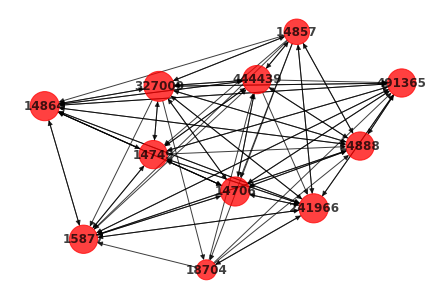

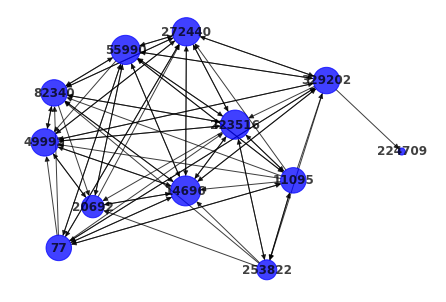

In [ ]:
plot_passing_networks(G1, G2)

In [ ]:
G1.get_edge_data('Mário Rui', 'K. Koulibaly')

In [ ]:
G1.get_edge_data('K. Koulibaly', 'Mário Rui')

In [ ]:
G11=nx.DiGraph()
for edge in G1.edges:
  weight_=G1.get_edge_data(edge[0], edge[1])['weight']
  if 'contraction' in G1.get_edge_data(edge[0], edge[1]).keys():
    for value in G1.get_edge_data(edge[0], edge[1])['contraction'].values():
      weight_+=value['weight']
    G11.add_edge(edge[0], edge[1], weight=weight_)
  else:
    G11.add_edge(edge[0], edge[1], weight=weight_)

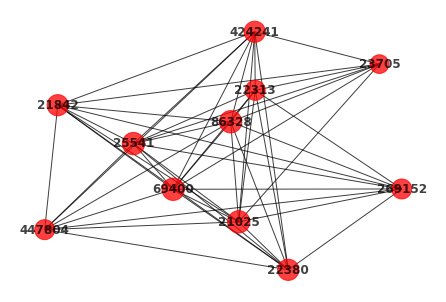

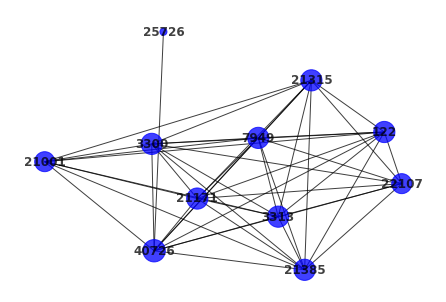

In [ ]:
G12=G1.to_undirected()
G21=G2.to_undirected()
plot_passing_networks(G12, G21)

In [ ]:
passes=nx.to_numpy_matrix(G1)
passes

matrix([[ 0.,  2.,  2.,  2.,  7.,  3.,  3.,  0.,  0.,  0.,  0.],
        [ 5.,  0.,  6.,  6., 10.,  6.,  2.,  1.,  4.,  0.,  0.],
        [ 1.,  7.,  0.,  4., 11.,  1., 12.,  2., 15.,  9.,  1.],
        [ 3.,  4.,  5.,  0.,  9.,  5.,  5.,  3., 10.,  3.,  0.],
        [ 7.,  6.,  4.,  3.,  0.,  3.,  2.,  1.,  2.,  1.,  0.],
        [ 5.,  9.,  0.,  4.,  3.,  0.,  5.,  5.,  1.,  3.,  0.],
        [ 4.,  3.,  2.,  3.,  2.,  5.,  0.,  0.,  2.,  5.,  1.],
        [ 2.,  4.,  1.,  5.,  0., 12.,  2.,  0.,  2.,  8.,  4.],
        [ 2.,  7., 12.,  7.,  5.,  1.,  1.,  8.,  0.,  8.,  0.],
        [ 0.,  5., 13.,  5.,  2.,  1.,  1.,  6., 10.,  0.,  4.],
        [ 0.,  0.,  3.,  0.,  0.,  2.,  0.,  7.,  0.,  2.,  0.]])

In [ ]:
nx.to_numpy_matrix(G2)

matrix([[ 0.,  7.,  4.,  6.,  3.,  3.,  4.,  2.,  4.,  1.,  0.],
        [ 4.,  0.,  4.,  5.,  2.,  6.,  3.,  9.,  0.,  0.,  1.],
        [ 5.,  1.,  0., 18.,  5.,  5., 10.,  2.,  5.,  9.,  1.],
        [ 1.,  8., 15.,  0.,  9., 10., 20.,  3., 19.,  3.,  2.],
        [ 1.,  0., 12., 13.,  0.,  5.,  3.,  0.,  1.,  5.,  4.],
        [ 1.,  3.,  5.,  7., 12.,  0.,  4.,  3.,  0.,  1.,  2.],
        [ 5.,  2.,  6., 15.,  2.,  6.,  0.,  3.,  6.,  9.,  0.],
        [ 6.,  5.,  3.,  4.,  1.,  2.,  5.,  0.,  3.,  2.,  1.],
        [ 9.,  1.,  5.,  8.,  3.,  1.,  4.,  3.,  0.,  9.,  2.],
        [ 1.,  0.,  5.,  6.,  3.,  3.,  1.,  0.,  7.,  0.,  5.],
        [ 0.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,  3.,  0.]])

In [ ]:
nx.to_numpy_matrix(G1.subgraph(max(nx.strongly_connected_components(G1), key=len)).copy())

matrix([[ 0.,  2.,  2.,  2.,  3.,  7.,  3.,  0.,  0.,  0.,  0.,  0.],
        [ 5.,  0.,  6.,  6.,  2., 10.,  6.,  1.,  4.,  0.,  0.,  0.],
        [ 1.,  7.,  0.,  4., 12., 11.,  1.,  2., 15.,  9.,  1.,  0.],
        [ 3.,  4.,  5.,  0.,  5.,  9.,  5.,  3., 10.,  3.,  0.,  0.],
        [ 4.,  3.,  6.,  3.,  0.,  2.,  5.,  0.,  2.,  5.,  1.,  0.],
        [ 7.,  6.,  4.,  3.,  4.,  0.,  3.,  1.,  2.,  1.,  0.,  1.],
        [ 5.,  9.,  0.,  4.,  5.,  3.,  0.,  5.,  1.,  3.,  0.,  0.],
        [ 2.,  4.,  1.,  5.,  2.,  0., 12.,  0.,  2.,  8.,  4.,  0.],
        [ 2.,  7., 12.,  7.,  1.,  5.,  1.,  8.,  0.,  8.,  0.,  0.],
        [ 0.,  5., 13.,  5.,  1.,  2.,  1.,  6., 10.,  0.,  4.,  0.],
        [ 0.,  0.,  3.,  0.,  0.,  0.,  2.,  7.,  0.,  2.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])

In [ ]:
np.mean(np.sum(nx.to_numpy_matrix(G1), axis=1))

37.45454545454545

In [ ]:
if nx.is_strongly_connected(G2):
  nx.diameter(G2)
else:
  print(nx.diameter(G2.subgraph(max(nx.strongly_connected_components(G2), key=len)).copy()))

2


In [ ]:
nx.diameter(G1)

2

In [ ]:
np.round(np.mean(list(nx.betweenness_centrality(G1).values())),3)

0.02

In [ ]:
np.round(np.mean(list(nx.betweenness_centrality(G12).values())),3)

0.012

In [ ]:
passes.sum()

412.0

In [ ]:
pA=(passes+1/100000)/passes.sum()
Shannon2 = np.round(-(1/(passes.sum()*np.log2(passes.sum())))*np.sum(pA*np.log2(pA)),3)
Shannon2

0.034

### Getting the final dataframe

In [ ]:
matches_final=pd.read_csv('https://raw.githubusercontent.com/mebalint/hgt/main/dataafterpossession.csv', sep='\t', index_col=0)
matches_final=matches_final.set_index('match_id')
matches_final=matches_final.rename(columns={"HPossession": "home_possession", "APossession": "away_possession"})
matches_final

,home,away,home_goal,away_goal,roundId,gameweek,competitionId,home_corner,away_corner,home_pass,...,away_shot,home_shot_on_target,away_shot_on_target,home_free_kick,away_free_kick,home_odds,draw_odds,away_odds,home_possession,away_possession
match_id,,,,,,,,,,,,,,,,,,,,,
2576335,Lazio,Inter,2,3,4406278,38,524,10,3,302,...,14,4,6,14,13,2.58,3.61,2.68,0.40,0.60
2576336,Sassuolo,AS Roma,0,1,4406278,38,524,5,9,337,...,15,3,6,12,16,4.53,3.77,1.78,0.42,0.58
2576329,Cagliari,Atalanta,1,0,4406278,38,524,5,11,232,...,11,4,4,16,15,3.18,3.57,2.21,0.31,0.69
2576330,Chievo,Benevento,1,0,4406278,38,524,2,4,198,...,10,4,2,12,15,1.69,3.99,4.90,0.24,0.76
2576331,Udinese,Bologna,1,0,4406278,38,524,10,2,327,...,8,5,4,13,11,1.51,4.25,6.60,0.41,0.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499766,Tottenham,Swansea,0,0,4405654,5,364,11,1,753,...,3,7,0,9,10,1.22,7.17,14.03,0.75,0.25
2499746,Tottenham,Burnley,1,1,4405654,3,364,10,7,573,...,13,6,3,15,9,1.22,6.78,14.99,0.66,0.34
2499737,Tottenham,Chelsea,1,2,4405654,2,364,14,3,569,...,7,6,2,20,13,2.15,3.40,3.70,0.68,0.32


In [ ]:
# stats for network measures
home_degree={}
away_degree={}
home_diameter={}
away_diameter={}
home_bet_cent={}
away_bet_cent={}
home_entropy={}
away_entropy={}
for index in matches_final.index:
  #print(index)
  G1, G2 = passing_networks(index)
  home_degree[index]=np.round(np.mean(np.sum(nx.to_numpy_matrix(G1), axis=1)),3)
  away_degree[index]=np.round(np.mean(np.sum(nx.to_numpy_matrix(G2), axis=1)),3)
  if nx.is_strongly_connected(G1):
    home_diameter[index]=nx.diameter(G1)
  else:
    home_diameter[index]=nx.diameter(G1.subgraph(max(nx.strongly_connected_components(G1), key=len)).copy())
  if nx.is_strongly_connected(G2):
    away_diameter[index]=nx.diameter(G2)
  else:
    away_diameter[index]=nx.diameter(G2.subgraph(max(nx.strongly_connected_components(G2), key=len)).copy())
  home_bet_cent[index]=np.round(np.mean(list(nx.betweenness_centrality(G1).values())),3)
  away_bet_cent[index]=np.round(np.mean(list(nx.betweenness_centrality(G2).values())),3)
  passes_1=nx.to_numpy_matrix(G1)
  pA_1=(passes_1+1/100000)/passes_1.sum()
  entropy_1 = np.round(-(1/(passes_1.sum()*np.log2(passes_1.sum())))*np.sum(pA_1*np.log2(pA_1)),3)
  passes_2=nx.to_numpy_matrix(G2)
  pA_2=(passes_2+1/100000)/passes_2.sum()
  entropy_2 = np.round(-(1/(passes_2.sum()*np.log2(passes_2.sum())))*np.sum(pA_2*np.log2(pA_2)),3)
  home_entropy[index]=entropy_1
  away_entropy[index]=entropy_2

matches_final['home_degree']=matches_final.index.map(home_degree)
matches_final['away_degree']=matches_final.index.map(away_degree)
matches_final['home_diameter']=matches_final.index.map(home_diameter)
matches_final['away_diameter']=matches_final.index.map(away_diameter)
matches_final['home_bet_cent']=matches_final.index.map(home_bet_cent)
matches_final['away_bet_cent']=matches_final.index.map(away_bet_cent)
matches_final['home_entropy']=matches_final.index.map(home_entropy)
matches_final['away_entropy']=matches_final.index.map(away_entropy)

In [ ]:
matches_final

,home,away,home_goal,away_goal,roundId,gameweek,competitionId,home_corner,away_corner,home_pass,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
match_id,,,,,,,,,,,,,,,,,,,,,
2576335,Lazio,Inter,2,3,4406278,38,524,10,3,302,...,0.40,0.60,22.000,37.545,2,2,0.027,0.019,0.072,0.032
2576336,Sassuolo,AS Roma,0,1,4406278,38,524,5,9,337,...,0.42,0.58,23.182,36.909,2,2,0.024,0.011,0.066,0.032
2576329,Cagliari,Atalanta,1,0,4406278,38,524,5,11,232,...,0.31,0.69,15.545,45.909,2,2,0.037,0.019,0.111,0.027
2576330,Chievo,Benevento,1,0,4406278,38,524,2,4,198,...,0.24,0.76,12.818,55.364,2,2,0.042,0.025,0.144,0.021
2576331,Udinese,Bologna,1,0,4406278,38,524,10,2,327,...,0.41,0.59,24.636,39.636,3,2,0.033,0.019,0.064,0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499766,Tottenham,Swansea,0,0,4405654,5,364,11,1,753,...,0.75,0.25,60.636,13.909,2,3,0.013,0.037,0.018,0.130
2499746,Tottenham,Burnley,1,1,4405654,3,364,10,7,573,...,0.66,0.34,44.909,18.545,2,2,0.016,0.026,0.026,0.086
2499737,Tottenham,Chelsea,1,2,4405654,2,364,14,3,569,...,0.68,0.32,43.545,17.091,2,2,0.009,0.030,0.025,0.098


In [ ]:
matches_final['match_id']=matches_final.index
matches_final=matches_final.reset_index(drop=True)

In [ ]:
matches_final.to_csv('matches_final.csv', sep='\t')

### trying

In [ ]:
match_events = []
for event in match_id2events[2576331]:
  if event['eventName'] == 'Pass':
    match_events.append(event)

match_events_df = pd.DataFrame(match_events)
match_events_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],333913,"[{'y': 48, 'x': 50}, {'y': 51, 'x': 39}]",2576331,Pass,3163,1H,1.838345,85,253649390
1,8,Simple pass,[{'id': 1801}],213948,"[{'y': 51, 'x': 39}, {'y': 63, 'x': 32}]",2576331,Pass,3163,1H,2.509925,85,253649391
2,8,Simple pass,[{'id': 1801}],134508,"[{'y': 63, 'x': 32}, {'y': 36, 'x': 27}]",2576331,Pass,3163,1H,4.892580,85,253649382
3,8,Simple pass,[{'id': 1801}],394,"[{'y': 36, 'x': 27}, {'y': 20, 'x': 28}]",2576331,Pass,3163,1H,7.234245,85,253649383
4,8,Simple pass,[{'id': 1801}],248950,"[{'y': 20, 'x': 28}, {'y': 71, 'x': 32}]",2576331,Pass,3163,1H,9.765844,85,253649384
...,...,...,...,...,...,...,...,...,...,...,...,...
840,8,Simple pass,[{'id': 1801}],234533,"[{'y': 23, 'x': 30}, {'y': 12, 'x': 45}]",2576331,Pass,3163,2H,70777.749498,85,253650648
841,8,Launch,[{'id': 1801}],20604,"[{'y': 66, 'x': 39}, {'y': 24, 'x': 85}]",2576331,Pass,3166,2H,70809.588133,84,253651290
842,8,Smart pass,"[{'id': 302}, {'id': 901}, {'id': 1801}]",20707,"[{'y': 46, 'x': 89}, {'y': 54, 'x': 95}]",2576331,Pass,3166,2H,70813.401676,86,253651292
843,8,Simple pass,[{'id': 1801}],21169,"[{'y': 85, 'x': 77}, {'y': 65, 'x': 70}]",2576331,Pass,3166,2H,70824.343371,85,253651297


In [ ]:
events=pd.DataFrame(match_id2events[2576331])
#passes=events[events['eventName']=='Pass']
#events[events['playerId']==388398]
events[events['eventSec']>=96911].head(10)
#events

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
1011,8,Simple pass,[{'id': 1801}],92908,"[{'y': 94, 'x': 70}, {'y': 84, 'x': 74}]",2576331,Pass,3166,2H,96911.958822,85,253650874
1012,1,Ground defending duel,"[{'id': 701}, {'id': 1802}]",21314,"[{'y': 16, 'x': 26}, {'y': 14, 'x': 23}]",2576331,Duel,3163,2H,96913.334273,12,253650057
1013,1,Ground defending duel,"[{'id': 502}, {'id': 701}, {'id': 1802}]",354547,"[{'y': 14, 'x': 23}, {'y': 16, 'x': 26}]",2576331,Duel,3163,2H,96914.672525,12,253650059
1014,1,Ground attacking duel,"[{'id': 703}, {'id': 1801}]",21123,"[{'y': 84, 'x': 74}, {'y': 86, 'x': 77}]",2576331,Duel,3166,2H,96914.952184,11,253650876
1015,1,Ground attacking duel,"[{'id': 501}, {'id': 703}, {'id': 1801}]",21123,"[{'y': 86, 'x': 77}, {'y': 89, 'x': 85}]",2576331,Duel,3166,2H,96915.228278,11,253650877
1016,1,Ground defending duel,"[{'id': 502}, {'id': 703}, {'id': 1801}]",248950,"[{'y': 11, 'x': 15}, {'y': 7, 'x': 2}]",2576331,Duel,3163,2H,96915.379424,12,253650060
1017,1,Ground attacking duel,"[{'id': 501}, {'id': 701}, {'id': 1802}]",0,"[{'y': 89, 'x': 85}, {'y': 93, 'x': 98}]",2576331,Duel,3166,2H,96915.379424,11,253651465
1018,7,Clearance,[{'id': 1802}],248950,"[{'y': 7, 'x': 2}, {'y': 0, 'x': 16}]",2576331,Others on the ball,3163,2H,96918.306325,71,253650062
1019,5,Ball out of the field,[],0,"[{'y': 0, 'x': 16}, {'y': 0, 'x': 0}]",2576331,Interruption,3163,2H,96921.816184,50,253650063
1020,3,Throw in,[{'id': 1801}],92908,"[{'y': 100, 'x': 89}, {'y': 88, 'x': 80}]",2576331,Free Kick,3166,2H,96935.431674,36,253650878


In [ ]:
for id in list(player_id2player.keys()):
  if id!=0 and player_id2player[id]['shortName'].encode('ascii', 'strict').decode('unicode-escape')=='S. Perica':
  #if :
  #try:
    #print(id)
    a=player_id2player[id]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
    print(id)
  #except KeyError:
    #pass 

234533


In [ ]:
match_id2match[2500967]['teamsData'][list(match_id2match[2500967]['teamsData'].keys())[1]]['formation']['substitutions']

[{'playerIn': 38095, 'playerOut': 26134, 'minute': 28},
 {'playerIn': 101795, 'playerOut': 26384, 'minute': 77}]

In [ ]:
player_id2player[327009]

{'passportArea': {'name': 'Brazil',
  'id': '76',
  'alpha3code': 'BRA',
  'alpha2code': 'BR'},
 'weight': 75,
 'firstName': 'Walace',
 'middleName': '',
 'lastName': 'Souza Silva',
 'currentTeamId': 2450,
 'birthDate': '1995-04-04',
 'height': 188,
 'role': {'code2': 'MD', 'code3': 'MID', 'name': 'Midfielder'},
 'birthArea': {'name': 'Brazil',
  'id': '76',
  'alpha3code': 'BRA',
  'alpha2code': 'BR'},
 'wyId': 327009,
 'foot': 'right',
 'shortName': 'Walace',
 'currentNationalTeamId': 'null'}

In [ ]:
print(home_degree)

{2576335: 18.181818181818183, 2576336: 20.272727272727273}


In [ ]:
team2team_id['Cagliari']

3173

### end